<a href="https://colab.research.google.com/github/Hemanthsai001/cs666student/blob/main/CS666_Assignment_6%2C_Others.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

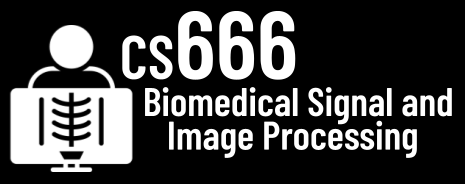
# Assignment 6

In [1]:
# NAME:

In [2]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [3]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [6]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-25 03:05:50--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz’

mito.npz            100%[===================>]  35.87M  90.4MB/s    in 0.4s    

2023-04-25 03:05:51 (90.4 MB/s) - ‘mito.npz’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [7]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

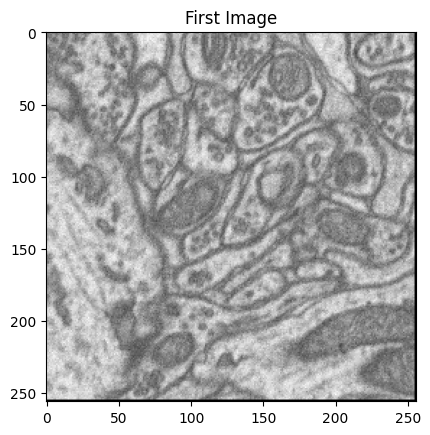

In [8]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
import matplotlib.pyplot as plt

plt.imshow(images[0], cmap='gray')
plt.title("First Image")
plt.show()

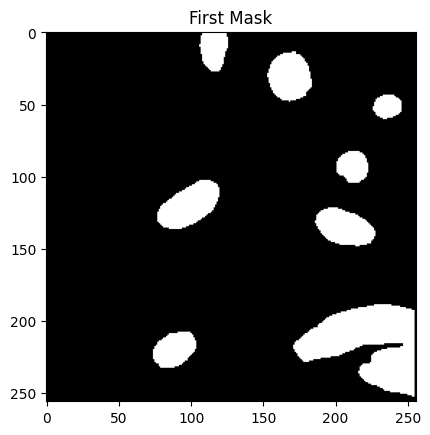

In [9]:
# TODO: Show the first mask.

plt.imshow(masks[0], cmap='gray')
plt.title("First Mask")
plt.show()

## 1. SAM in AUTO mode (15 points)

In [10]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for metaseg: filename=metaseg-0.6.1-py3-none-any.whl size=44772 sha256=b211f39e4aef7f053d693f8bbf2f4de10c8ab7ede489f6cbbe8915c9f4891e1c
  Stored in directory: /root/.cache/pip/wheels/b1/0c/bd/5e8d8f9aa755ac2f82e75b9391db0d403f760a4654b19c8b6c
Successfully built meta

In [11]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [12]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [13]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model has been successfully downloaded and saved as 'vit_l.pth'.


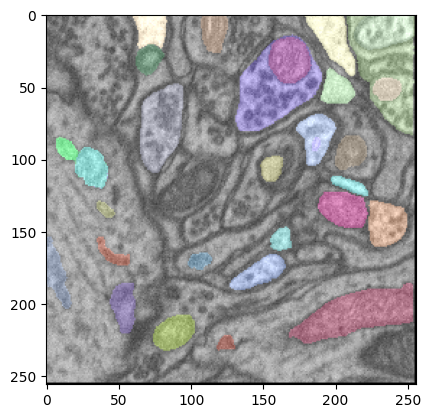

In [14]:
imshow( mh.imread('first_output.png') )

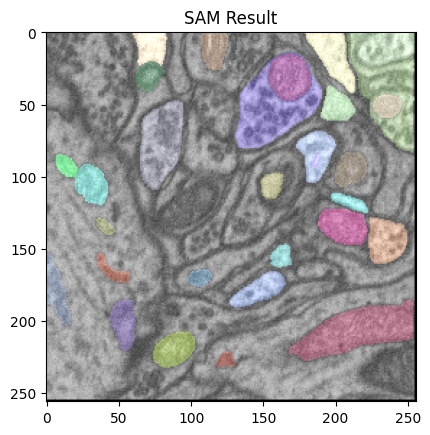

In [15]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: detected mitochondria in the output closely match the mask, then SAM works well for mitochondria detection.

# Load and display the SAM result
from PIL import Image

result_image = Image.open('first_output.png')
plt.imshow(result_image, cmap='gray')
plt.title("SAM Result")
plt.show()

SAM performs well for mitochondria detection when the output's detected mitochondria closely match the mask.

In [16]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

vit_l model already exists as 'vit_l.pth'. Skipping download.


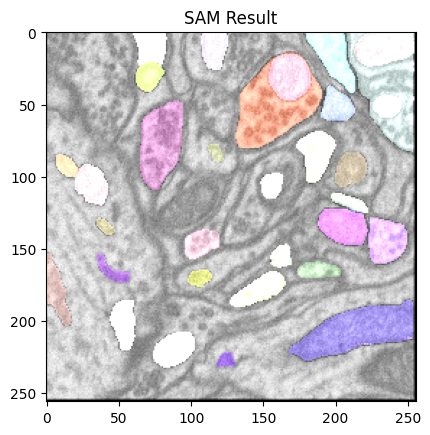

In [17]:
# TODO: YOUR CODE

uploaded_image = 'first_output.png'

# Run SAM in auto mode on the uploaded image and store the result as 'second_output.png'
results = SegAutoMaskPredictor().image_predict(
    source=uploaded_image,
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16,
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)

# Display the result
result_image = Image.open('second_output.png')
plt.imshow(result_image, cmap='gray')
plt.title("SAM Result")
plt.show()


In [18]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER

Following a visual comparison of the output and the original image, it can be seen that the output's identified segments closely match the original image's desired segments. SAM therefore performs nicely on the example image.

## 2. Train a U-Net classifier from scratch (50 points)


In [19]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


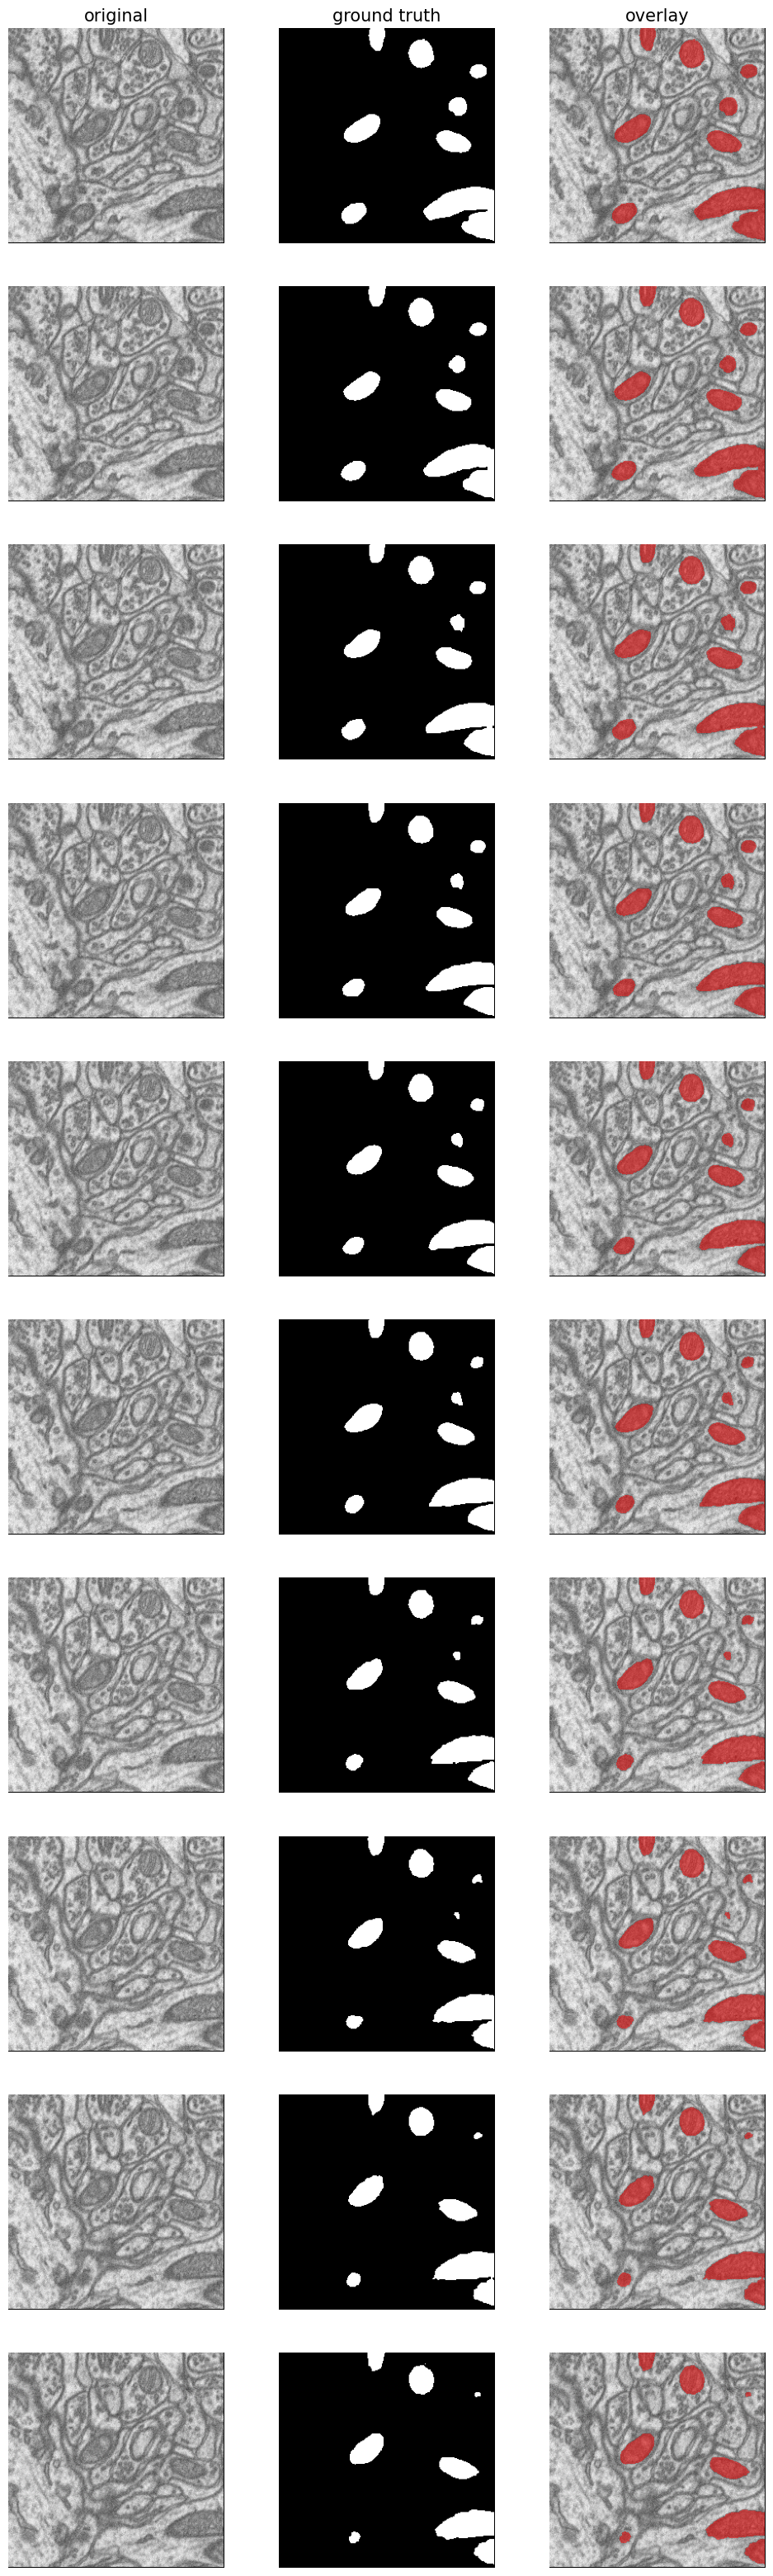

In [21]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [22]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [23]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# X = 


# Convert to float32
images_float32 = images.astype(np.float32)

# Normalize to the range of 0 to 1
images_normalized = images_float32 / images_float32.max()

# Add the last channel using .reshape()
X = images_normalized.reshape(images_normalized.shape + (1,))

# Check the resulting shape, max value, and dtype
print(X.shape, X.max(), X.dtype)

(660, 256, 256, 1) 1.0 float32


In [24]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [25]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [26]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 

# Convert to bool
masks_bool = masks.astype(np.bool)

# Add the last channel using .reshape()
y = masks_bool.reshape(masks_bool.shape + (1,))

# Check the resulting shape and dtype
print(y.shape, y.dtype)

(660, 256, 256, 1) bool


<ipython-input-26-825f8b10e1e5>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks_bool = masks.astype(np.bool)


In [27]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [28]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [31]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [32]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER

To construct three unique datasets for training, validation, and testing, we call train_test_split twice.

We divided the data into training (80% of the data) and testing (20% of the data) in the first call to train_test_split. The test_size=0.2 option is used to do this.

Following that, we further divided the training data into two portions: training (70% of the original training data) and validation (30% of the original training data) in the second call to train_test_split. The test_size=0.3 option is used to do this.

As a result, we obtain three datasets:

Data utilised to train the model, or 56% of the total data. Validation data, which make up 24 percent of the total data, are used to assess the model after training and adjust the hyperparameters. Data utilised for testing (20% of the total data): used to evaluate the model's performance after training. This method prevents overfitting and gives a more accurate assessment of the model's performance on unobserved data because it guarantees that we have distinct data for training, hyperparameter tuning, and final model evaluation.

In [33]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [34]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

The approach of "data augmentation" involves adding random changes to the original images and masks in order to improve the quantity and diversity of the training data. This reduces overfitting and improves the generalizability of the model.

The following arguments are accepted by the get_augmented function:

* Images used for training.
* matching training masks for y_train.
* batch_size: During training, the number of samples in each batch.
* Data augmentation parameters are contained in a dictionary called data_gen_args.

The following keys and values are found in the data_gen_args dictionary:
* rotation_range: The range of random rotation degrees, which is currently set to 15.
* width_shift_range: The range for arbitrary horizontal shifts expressed as a percentage of the whole width, which is currently set to 5%.
* height_shift_range: Here, it is set to 5%. This is the range for random vertical shifts as a percentage of the entire height.
* shear_range: Set to 50 degrees in this instance, the range for random shearing transformations.
* zoom_range: The zoom range, which is currently set to 20%.
* horizontal_flip: Set to True here to flip photos horizontally at random.
* vertical_flip: Set to True to randomly flip the images' vertical orientation.
* Fill_mode is used to fill points outside the input limits; in this case, it is set to "constant" to fill with a fixed value.

During model training, the generator train_gen now produces augmented image and mask pairs in batches of two. Due to the model's ability to train on a virtually larger and more varied dataset, this can enhance both the model's performance and generalisation skills.

(2, 256, 256, 1) (2, 256, 256, 1)


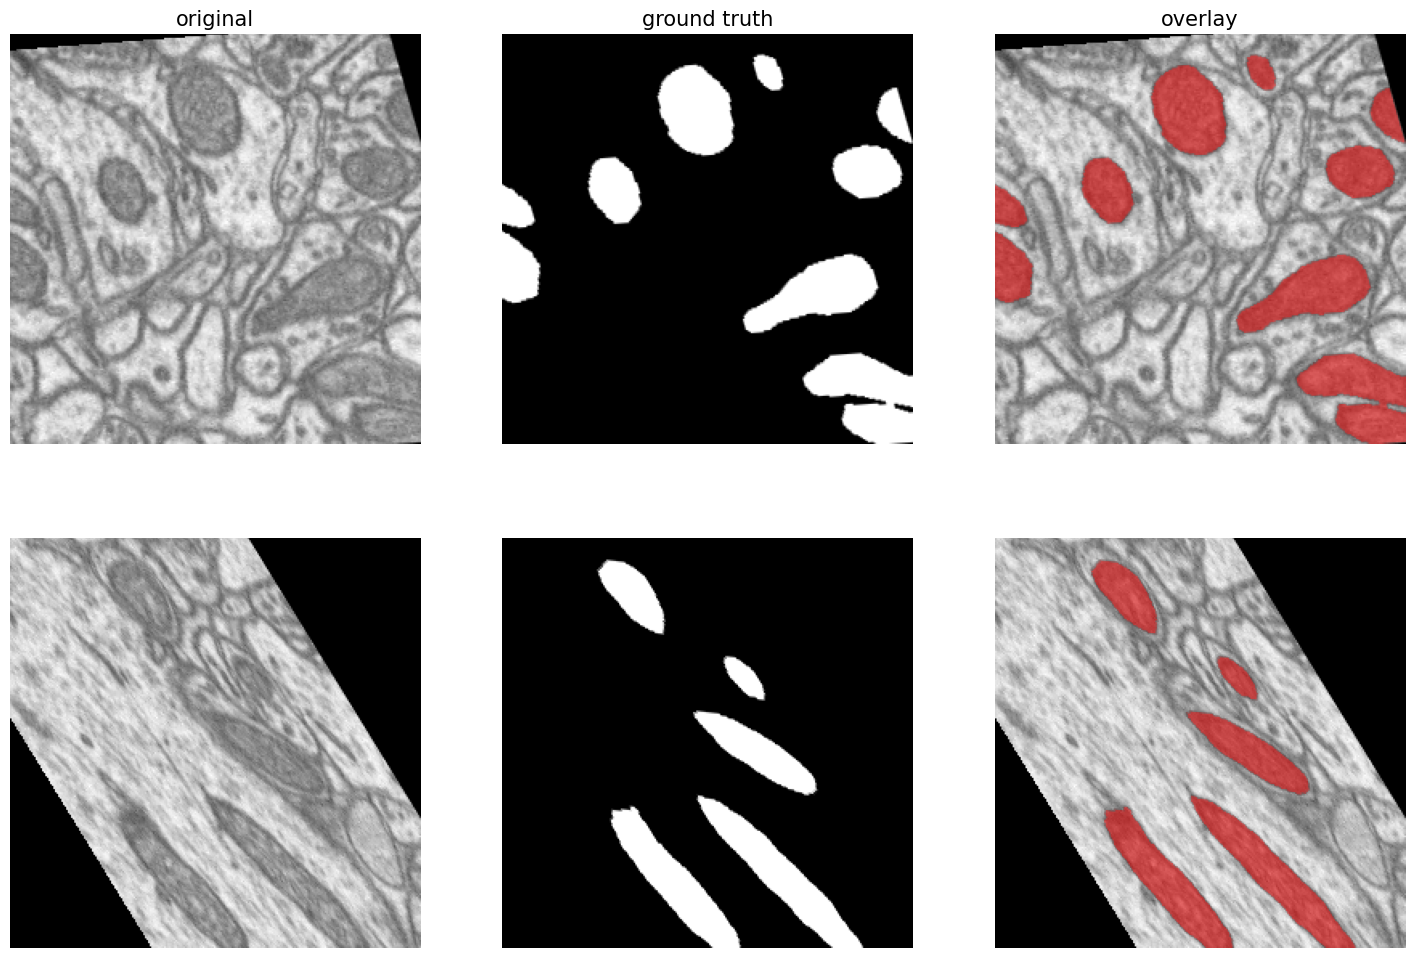

In [35]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [36]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [37]:
# TODO: How many  trainable parameters does the model use?
# TODO: Trainable params: 31,030,593

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [38]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [39]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [40]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

A popular assessment metric for segmentation problems is intersect-over-union (IoU). It provides a quantitative assessment of the model's performance by measuring the overlap between the anticipated segmentation mask and the ground truth mask. IoU is the intersection of the anticipated and real-world masks, split by the union of those masks.

The IoU score is between 0 and 1. Scores range from 0 for no overlap to 1 for an exact match between the expected and ground truth masks. Better segmentation performance is correlated with higher IoU scores, which show more agreement between the anticipated and ground truth masks.

In [41]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(

    train_gen,
    steps_per_epoch=len(X_train),
    epochs=30,
    validation_data=(X_val, y_val),
)

Epoch 1/30
369/369 [==============================] - 106s 265ms/step - loss: 0.2341 - iou: 0.0571 - iou_thresholded: 1.9201e-04 - val_loss: 0.1977 - val_iou: 0.1030 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 57s 154ms/step - loss: 0.1581 - iou: 0.1690 - iou_thresholded: 0.1442 - val_loss: 0.1557 - val_iou: 0.2433 - val_iou_thresholded: 0.3897
Epoch 3/30
369/369 [==============================] - 57s 156ms/step - loss: 0.1288 - iou: 0.2738 - iou_thresholded: 0.3417 - val_loss: 0.1040 - val_iou: 0.3848 - val_iou_thresholded: 0.4577
Epoch 4/30
369/369 [==============================] - 58s 156ms/step - loss: 0.0943 - iou: 0.4004 - iou_thresholded: 0.4844 - val_loss: 0.0846 - val_iou: 0.4848 - val_iou_thresholded: 0.6437
Epoch 5/30
369/369 [==============================] - 58s 156ms/step - loss: 0.0903 - iou: 0.4217 - iou_thresholded: 0.5158 - val_loss: 0.0596 - val_iou: 0.6211 - val_iou_thresholded: 0.7446
Epoch 6/30
369/369 [================

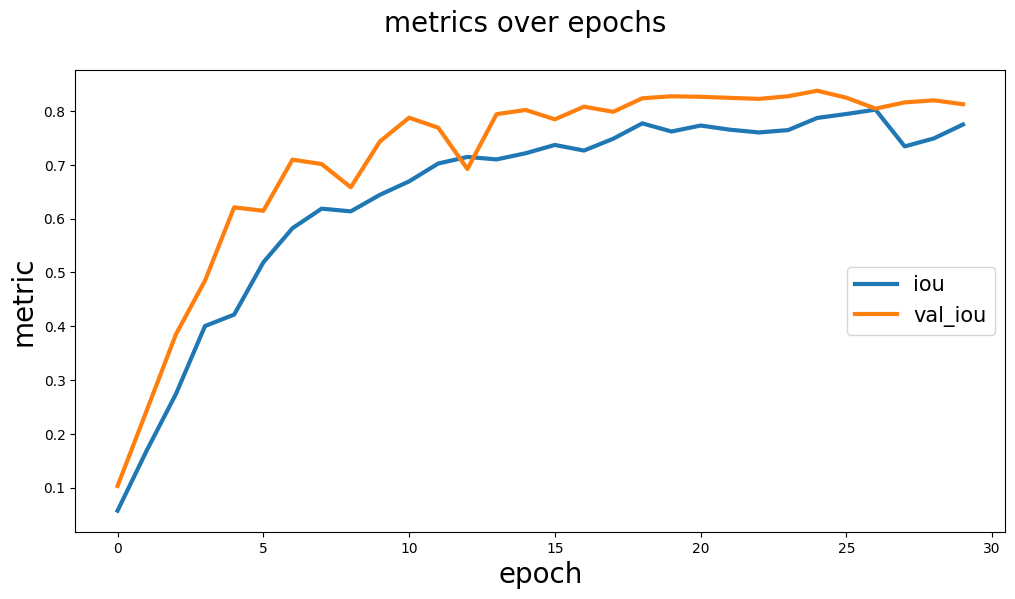

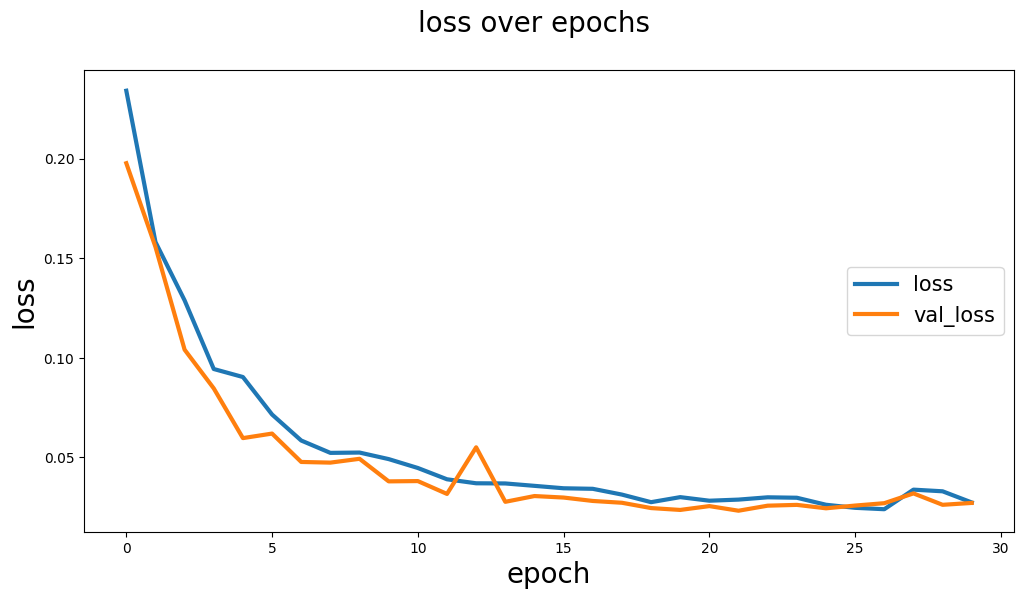

In [42]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [43]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

Training Loss and Validation Loss: Ideally, both the training and validation loss should decrease over time and converge to a low value, which is a good sign.

IoU and Thresholded IoU: The Intersection-over-Union (IoU) and thresholded IoU metrics should ideally increase over time, approaching a high value close to 1. A higher IoU indicates better performance of the model in terms of mask prediction.

## 3. Evaluate U-Net (10 points)

In [44]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 6s 1s/step


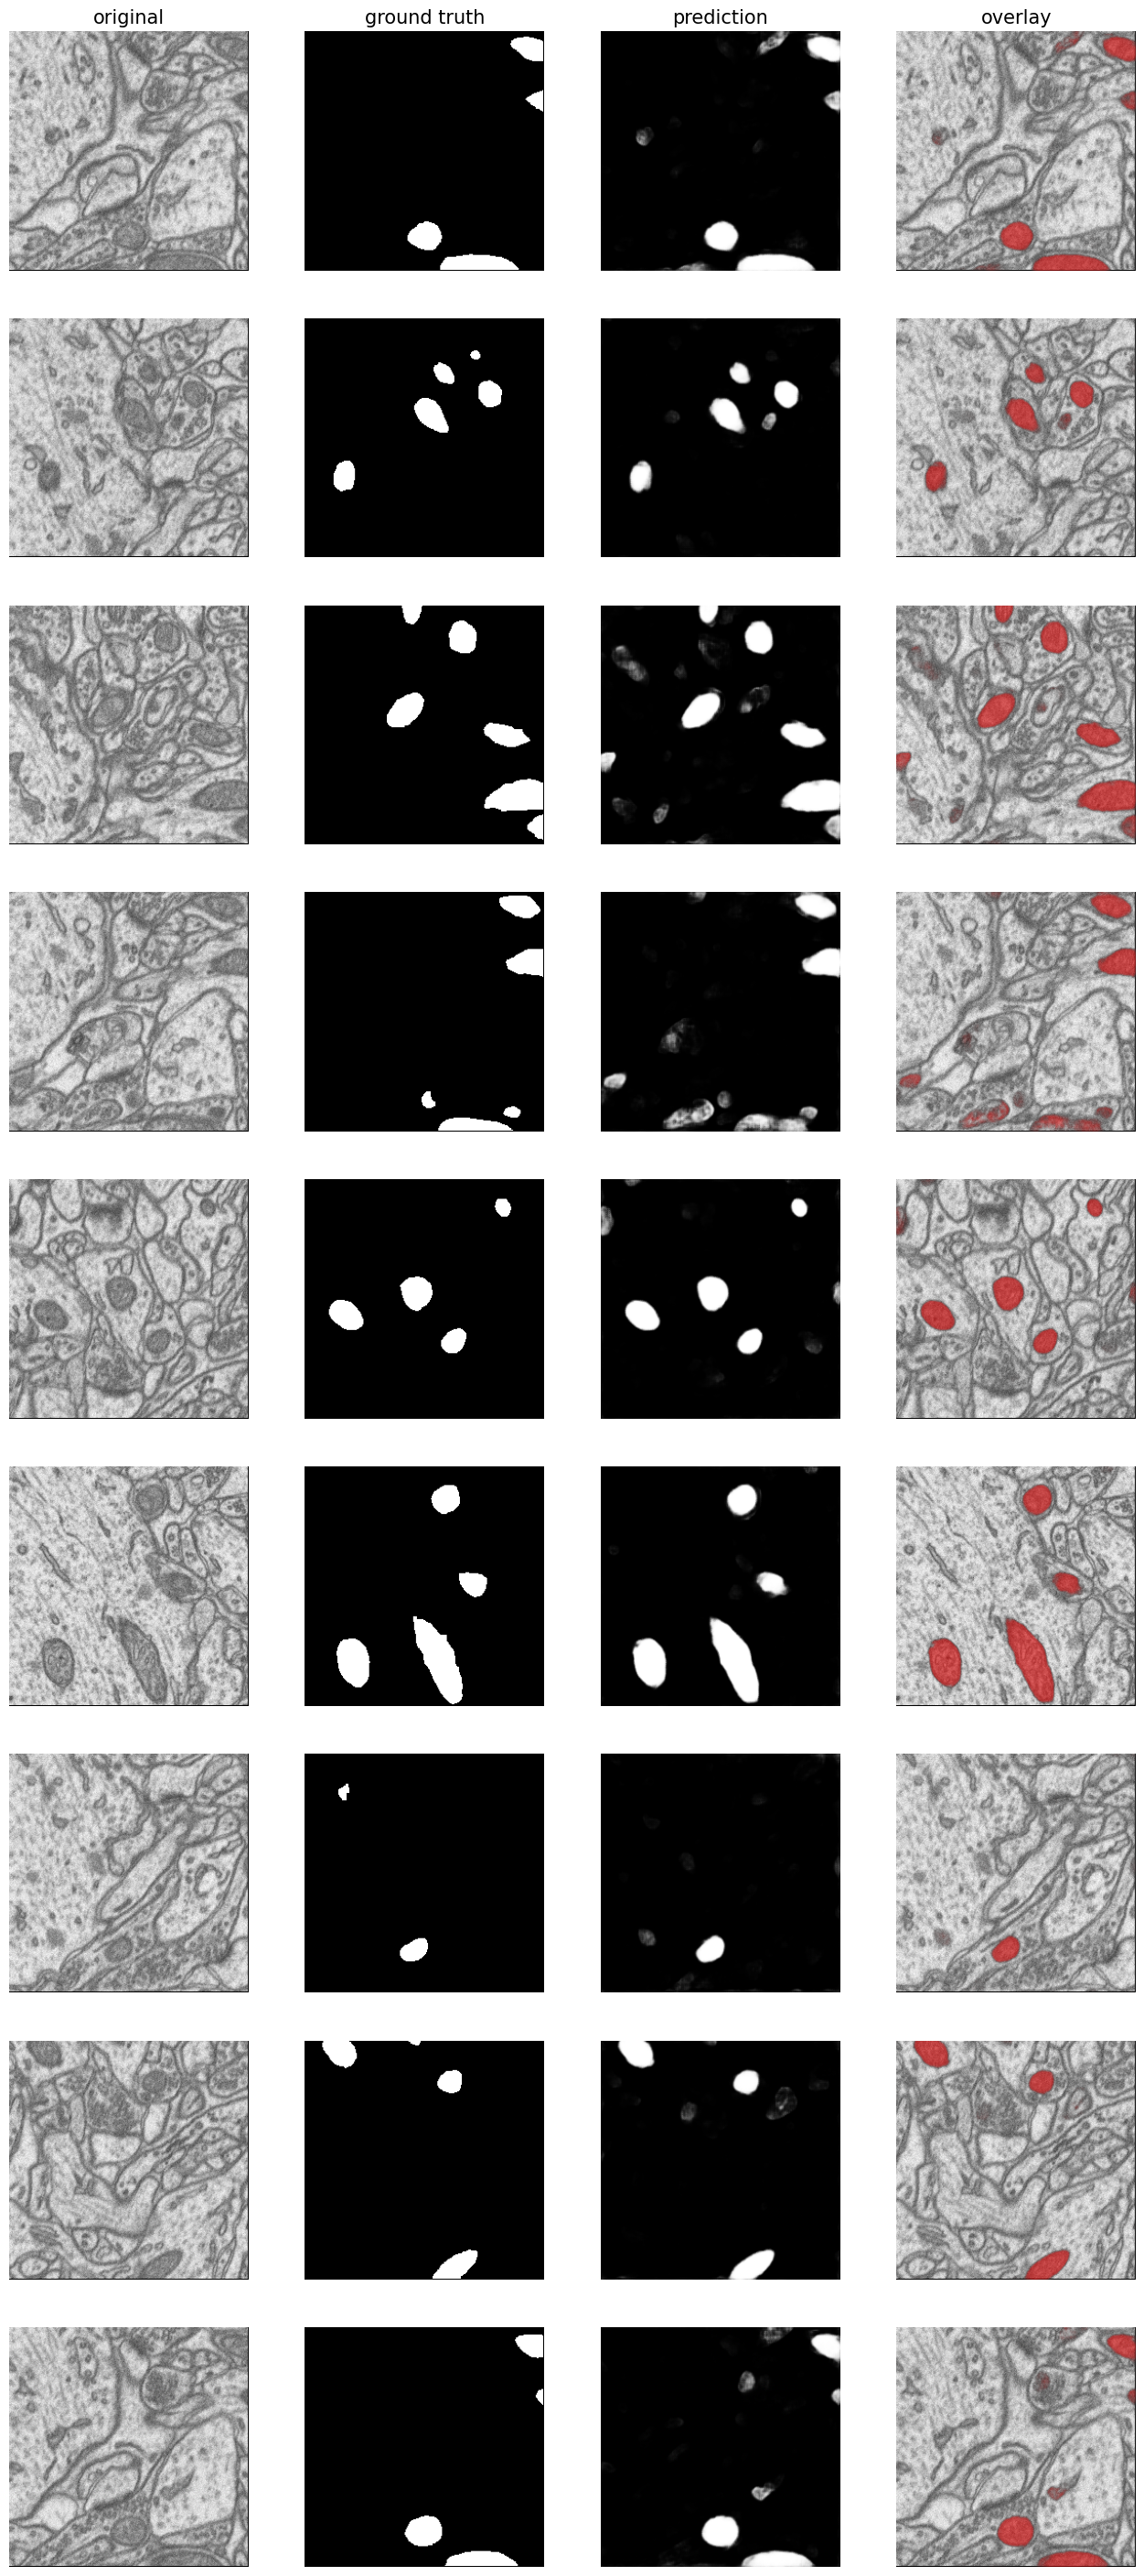

In [45]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [46]:
import sklearn.metrics

In [47]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8718698070574448

In [48]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 

Intersect-over-Union (IoU) and the Jaccard Score are essentially the same metric. Both assess how much two sets—in this instance, the anticipated segmentation mask and the ground truth mask—of data overlap. The metric is calculated by dividing the intersection's area by the union's area.

In [49]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER

The U-Net on X_test has a given Jaccard Score (IoU) of 0.8868, which is near to 1. This shows that there is substantial overlap between the ground truth masks and the anticipated segmentation masks. It is clear from this statistic that the U-Net performed well on the X_test dataset.

## 4. Combine U-Net with SAM (10 points)

In [50]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [51]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [52]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [53]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [54]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [55]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

mh.imsave('test.png', (img[:,:,0]*255) will save the test picture to disc.astype(np.uint8))

This line of code copies the current test image img from X_test to a file called test.png with the same data type (np.uint8) and pixel values (normalised values are multiplied by 255 to return to the 0-255 range).

U-Net prediction threshold: pred = (y_pred[z] > 0.5)

By thresholding the predicted mask at a value of 0.5, this line produces a binary mask called pred.

The thresholded prediction's associated components should be identified:
_ = mh.labeled, pred =.label(pred)

This line assigns the outcome back to the thresholded prediction pred and names the related components in pred. The second output, which is the quantity of linked components, is set to the fictitious variable _ because it is not required.

Bounding boxes for related components should be calculated.

"bbs = mh.labeled.bbox(pred)"

The labelled pred image's linked components' bounding boxes are determined and saved in the bbs variable by this line.


Mahotas bounding boxes should be converted to SAM format.

The formula "bbs_converted = mahotas_bbox_to_sam(bbs)"

Using the mahotas_bbox_to_sam function, the bounding boxes are converted from the mahotas format to the SAM format in this line.


Running the SAM model with the updated bounding boxes:

results are equal to SegManualMaskPredictor().source="test.png", model_type="vit_l", # vit_l, vit_h, vit_b input_box=bbs_converted, multimask_output=False, random_color=False, show=False, save=False, ) image_predict

Using the SegManualMaskPredictor and bounding boxes that have been seeded with U-Net (bbs_converted), this line performs the SAM model. The saved test image "test.png" is used as input by the SAM model to forecast the segmentation mask.


Combine the output tensors from the SAM to a mask:

Sam_and_unet_pred is equal to Sam_to_mask(results).

The sam_to_mask function is used in this line to merge the SAM output tensors into a single binary mask.


The combined SAM and U-Net prediction should be stored in y_pred_sam.

`y_pred_sam[z,:,:,0] = Sam and the Unpredator

For the current test image z, this line saves the combined SAM and U-Net prediction (sam_and_unet_pred) in the y_pred_sam array.

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [56]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8718698070574448

In [57]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8349412371266534

In [58]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER

The outcomes demonstrate that the performance of U-Net alone on X_test is superior to that of U-Net and SAM combined (Jaccard Score of 0.88 vs. 0.81, respectively). As the performance has slightly deteriorated while utilising the combined strategy, it appears that U-Net+SAM is not a beneficial addition in this scenario. This may be the result of several things, such inadequate seeding or potential SAM model setup problems.

The SAM model could not be well adapted for the specific task of mitochondria identification or might need to be fine-tuned for this particular application, which could be one explanation for the combined approach's less effective performance. It's also likely that the U-Net forecasts' seed information is not being used by the SAM model efficiently; this issue might be looked into more and rectified.

In light of the findings, it may be concluded that U-Net alone performs better than U-Net+SAM in this particular task. The combined technique could benefit from more research and optimisation.

## Bonus: Improve the results. (33 points)

In [59]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [60]:
# TODO: YOUR_CODE

In [ ]:
from skimage.morphology import binary_closing
import warnings
warnings.filterwarnings('ignore')

points_per_side = 32
points_per_batch = 128
model_type = "vit_l"

def sam_to_mask(results):
    results = results.cpu()
    mask = np.array(results[0,0])
    for s in results:
        mask[s[0] == 1] = 1
    mask = binary_closing(mask, selem=np.ones((5,5)))
    
    return mask

y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))
  pred = (y_pred[z] > 0.5)
  pred, _ = mh.labeled.label(pred)
  bbs = mh.labeled.bbox(pred)
  bbs_converted = mahotas_bbox_to_sam(bbs)
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type=model_type,
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )
  sam_and_unet_pred = sam_to_mask(results)
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

  # Calculate the Jaccard score for the improved U-Net+SAM
  jaccard_score_improved = sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())
  print("Improved Jaccard score for U-Net+SAM: ", jaccard_score_improved)

vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.0044642572229065215
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.008088462777442885
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.015497450501547199
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.01845978409850724
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.022483275295074132
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.03035445007063604
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.031213891181512285
vit_l model already exists as 'vit_l.pth'. Skipping download.
Improved Jaccard score for U-Net+SAM:  0.03461139501908052
vit_l model already exists

Improved Jaccard score for U-Net+SAM:  0.83799583950758

In [ ]:
#Collab With Bharath Prakash Reddy Kanama
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#